
This page uses data from the OpenPowerlifting project, https://www.openpowerlifting.org.
You may download a copy of the data at https://gitlab.com/openpowerlifting/opl-data.


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from glob import glob
from urllib.request import urlretrieve

After importing the libraries, we need to see what we're working with for data

In [2]:

meets_df = pd.read_csv("meets.csv")
competitors_df = pd.read_csv("openpowerlifting.csv")
print(meets_df.shape)
print(meets_df.head())
print(meets_df.info(verbose=True))
print(meets_df.describe())

(8482, 8)
   MeetID        MeetPath Federation        Date MeetCountry MeetState  \
0       0  365strong/1601  365Strong  2016-10-29         USA        NC   
1       1  365strong/1602  365Strong  2016-11-19         USA        MO   
2       2  365strong/1603  365Strong  2016-07-09         USA        NC   
3       3  365strong/1604  365Strong  2016-06-11         USA        SC   
4       4  365strong/1605  365Strong  2016-04-10         USA        SC   

    MeetTown                                           MeetName  
0  Charlotte  2016 Junior & Senior National Powerlifting Cha...  
1      Ozark                  Thanksgiving Powerlifting Classic  
2  Charlotte                             Charlotte Europa Games  
3  Rock Hill                   Carolina Cup Push Pull Challenge  
4  Rock Hill                              Eastern USA Challenge  
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8482 entries, 0 to 8481
Data columns (total 8 columns):
MeetID         8482 non-null int64
MeetPath

In [3]:
print(meets_df.MeetID.max(), competitors_df.MeetID.max())

8481 8481


Within the meets_df, there is a 'Date' column that should be converted to a datetime object, to use to explore when meets take place. We'll also take a look at what countries meets are taking place in.

In [4]:
meets_df['Date'] = pd.to_datetime(meets_df['Date'])
meets_df['Month'] = meets_df['Date'].apply(lambda x: x.month)
meets_df['Year'] = meets_df['Date'].apply(lambda x: x.year)
print(meets_df.head())

   MeetID        MeetPath Federation       Date MeetCountry MeetState  \
0       0  365strong/1601  365Strong 2016-10-29         USA        NC   
1       1  365strong/1602  365Strong 2016-11-19         USA        MO   
2       2  365strong/1603  365Strong 2016-07-09         USA        NC   
3       3  365strong/1604  365Strong 2016-06-11         USA        SC   
4       4  365strong/1605  365Strong 2016-04-10         USA        SC   

    MeetTown                                           MeetName  Month  Year  
0  Charlotte  2016 Junior & Senior National Powerlifting Cha...     10  2016  
1      Ozark                  Thanksgiving Powerlifting Classic     11  2016  
2  Charlotte                             Charlotte Europa Games      7  2016  
3  Rock Hill                   Carolina Cup Push Pull Challenge      6  2016  
4  Rock Hill                              Eastern USA Challenge      4  2016  


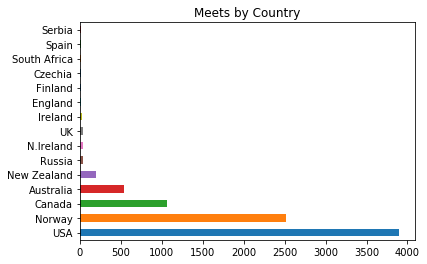

In [5]:
meets_df.MeetCountry.value_counts()[:15].plot(kind='barh')
type(meets_df.MeetCountry.value_counts())
plt.title('Meets by Country')
plt.show()

In [6]:
meets_by_dt = meets_df.sort_values(by='Date')
print(meets_by_dt.head())

      MeetID  MeetPath Federation       Date MeetCountry MeetState  \
2996    2996  nsf/2730        NSF 1974-03-02      Norway       NaN   
2997    2997  nsf/2731        NSF 1974-03-30      Norway       NaN   
2998    2998  nsf/2732        NSF 1974-04-27      Norway       NaN   
2999    2999  nsf/2733        NSF 1974-05-05      Norway       NaN   
3180    3180  nsf/3041        NSF 1974-06-15      Norway       NaN   

        MeetTown          MeetName  Month  Year  
2996        Oslo  Nasjonalt stevne      3  1974  
2997        Oslo  Nasjonalt stevne      3  1974  
2998         Ski      Åpent stevne      4  1974  
2999  Brumunddal                KM      5  1974  
3180   Trondheim   Kretsmesterskap      6  1974  


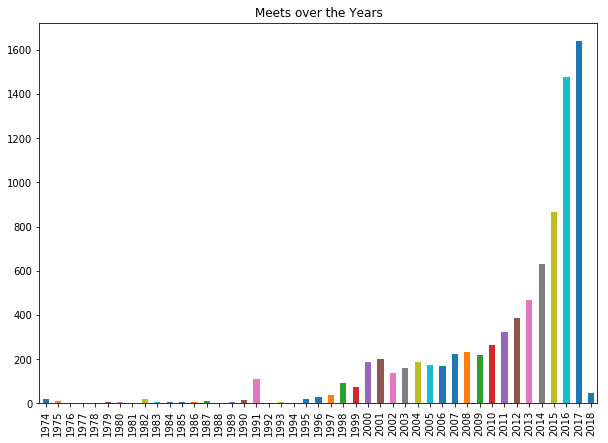

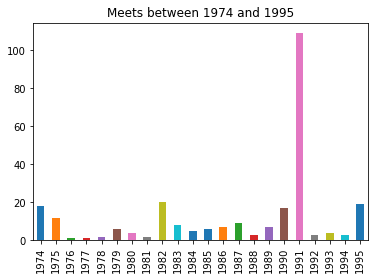

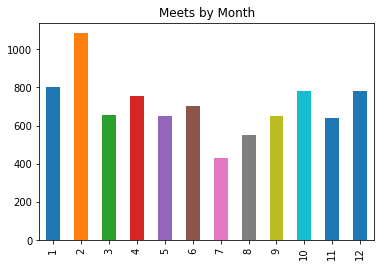

In [7]:
plt.figure(figsize=(10,7))
meets_df.Year.value_counts(sort=False).sort_index().plot(kind='bar')
plt.title('Meets over the Years')
plt.show()
meets_df.Year[(meets_df.Year < 1996) &(meets_df.Year >= 1974)].value_counts().sort_index().plot(kind='bar')
plt.title('Meets between 1974 and 1995')
plt.show()
meets_df.Month.value_counts().sort_index().plot(kind='bar')
plt.title('Meets by Month')
plt.show()

Now we're going to look at the competitors dataframe to see what sort of data it holds.

In [8]:
print(competitors_df.shape)
print(competitors_df.head())
print(competitors_df.info(verbose=True))
#print(competitors_df.describe())

(386414, 17)
   MeetID              Name Sex   Equipment   Age     Division  BodyweightKg  \
0       0  Angie Belk Terry   F       Wraps  47.0    Mst 45-49         59.60   
1       0       Dawn Bogart   F  Single-ply  42.0    Mst 40-44         58.51   
2       0       Dawn Bogart   F  Single-ply  42.0  Open Senior         58.51   
3       0       Dawn Bogart   F         Raw  42.0  Open Senior         58.51   
4       0      Destiny Dula   F         Raw  18.0   Teen 18-19         63.68   

  WeightClassKg  Squat4Kg  BestSquatKg  Bench4Kg  BestBenchKg  Deadlift4Kg  \
0            60       NaN        47.63       NaN        20.41          NaN   
1            60       NaN       142.88       NaN        95.25          NaN   
2            60       NaN       142.88       NaN        95.25          NaN   
3            60       NaN          NaN       NaN        95.25          NaN   
4          67.5       NaN          NaN       NaN        31.75          NaN   

   BestDeadliftKg  TotalKg Place   Wi

Right off there are a few things that look off with the data. For all the lift values, there are minimums that are negative. These were lifts that didn't qualify. For this data, we'll inspecty how many lifts were report as negative and determine how they should be handled. If there are a small number, we'll drop those records that contain negative lift values.

We also see that the Bench4Kg, Deadlift4Kg, and Squat4Kg columns are missing a large amount of data. For these, we'll drop the columns entirely. 

Another thing that will be considered, is what columns can be changed to categories. 

It seems the best way to uniquely identify a row is through MeetID and Name; these will be used for joint indexing. 

In [9]:
comps_slim = competitors_df.drop(['Squat4Kg', 'Bench4Kg', 'Deadlift4Kg'], axis=1)
comps_slim.columns


Index(['MeetID', 'Name', 'Sex', 'Equipment', 'Age', 'Division', 'BodyweightKg',
       'WeightClassKg', 'BestSquatKg', 'BestBenchKg', 'BestDeadliftKg',
       'TotalKg', 'Place', 'Wilks'],
      dtype='object')

In [10]:
comps_slim.Equipment = comps_slim.Equipment.astype('category')
comps_slim.Sex = comps_slim.Sex.astype('category')
print(comps_slim.Sex.unique()) 
print(comps_slim.Equipment.unique())

[F, M]
Categories (2, object): [F, M]
[Wraps, Single-ply, Raw, Multi-ply, Straps]
Categories (5, object): [Wraps, Single-ply, Raw, Multi-ply, Straps]


In [11]:
# Determine how frequent negative values occur 
percent_neg = len(comps_slim[(comps_slim['BestSquatKg'] < 0) | (comps_slim['BestBenchKg'] < 0) | (comps_slim['BestDeadliftKg'] < 0)])/len(comps_slim)
print('Percentage of lifts that are negative: ', str(percent_neg*100))

Percentage of lifts that are negative:  0.7554074127748994


Since it's a small percentage of records that contain a negative value, we'll drop those records.

In [17]:
comps_slim = comps_slim[(comps_slim.BestBenchKg > 0) | comps_slim.BestBenchKg.isnull()]
comps_slim = comps_slim[(comps_slim.BestSquatKg > 0) | comps_slim.BestSquatKg.isnull()]
comps_slim = comps_slim[(comps_slim.BestDeadliftKg > 0) | comps_slim.BestDeadliftKg.isnull()]


We want to look farther into missing values, such as those in the BodyweightKg and WeightClasskg. Depending on how many there are, we may just remove all those rows. If there are too many, we'll look at removing only those missing both BodyweightKg and WeightClassKg, Since BodyweightKg within a WeightClassKg is used to determind placement, we will need to remove all rows that have a missing BodyWeight. However, if we are just missing WeightClassKg, we can try to fit it into one of the WeightClassKg based off Sex / BodyweightKg.

In [24]:
comps_slim = comps_slim[(comps_slim.WeightClassKg.notnull())]
#print(comps_slim.info())
females = comps_slim[comps_slim.Sex == 'F']
males = comps_slim[comps_slim.Sex == 'M']
print(females.info())
print(males.info())
print(females.WeightClassKg.unique())
print(males.WeightClassKg.unique())

comps_slim = comps_slim[(comps_slim.BodyweightKg.notnull())]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 86021 entries, 0 to 386401
Data columns (total 14 columns):
MeetID            86021 non-null int64
Name              86021 non-null object
Sex               86021 non-null category
Equipment         86021 non-null category
Age               42298 non-null float64
Division          81800 non-null object
BodyweightKg      85788 non-null float64
WeightClassKg     86021 non-null object
BestSquatKg       70066 non-null float64
BestBenchKg       81109 non-null float64
BestDeadliftKg    76579 non-null float64
TotalKg           83665 non-null float64
Place             85789 non-null object
Wilks             83442 non-null float64
dtypes: category(2), float64(7), int64(1), object(4)
memory usage: 8.7+ MB
None
<class 'pandas.core.frame.DataFrame'>
Int64Index: 293666 entries, 23 to 386413
Data columns (total 14 columns):
MeetID            293666 non-null int64
Name              293666 non-null object
Sex               293666 non-null category
Equi

After farther examination, it shows that weight classes are not consistent across all Divisions, and trying to reclassify the missing BodyweightKg values would be tough, and not that much more insightful, seeing how few rows were missing it from the whole dataset. 

Missing values for BestSquatKg, BestBenchKg, and BestDeadliftKg are expected, as not everyone is successful at their lifts. Missing Ages may be problematic for viewing age distributions, but we can't disregard all rows that are missing these values becaus we'd lose far too much data. 



In [26]:
df_with_ages = comps_slim[comps_slim.Age.notnull()]
print(df_with_ages.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142180 entries, 0 to 385416
Data columns (total 14 columns):
MeetID            142180 non-null int64
Name              142180 non-null object
Sex               142180 non-null category
Equipment         142180 non-null category
Age               142180 non-null float64
Division          132503 non-null object
BodyweightKg      142180 non-null float64
WeightClassKg     142180 non-null object
BestSquatKg       107605 non-null float64
BestBenchKg       129222 non-null float64
BestDeadliftKg    120766 non-null float64
TotalKg           137336 non-null float64
Place             142141 non-null object
Wilks             137336 non-null float64
dtypes: category(2), float64(7), int64(1), object(4)
memory usage: 14.4+ MB
None
